In [11]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from common.classification import k_neighbours_leave_one_out, decision_tree_leave_one_out
from common.clustering import k_means_clustering, plot_means_in_clusters_for_given_column, \
    k_means_multiple_dim_silhouette, hierarchical_multiple_dim_silhouette, plot_clustering_scores, \
    perform_clustering_score_analysis
from common.outliers import find_outliers_in_multiple_columns, plot_2d_data_with_outliers, drop_outliers_from_dataset
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.linear_model import LinearRegression

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Dataset loading and preparation
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [12]:
# load dataset from file
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)

# choose 7th gen consoles
print(data["Platform"].unique())
seventh_gen = ["PS3", "Wii", "X360"]
data = data.loc[data["Platform"].isin(seventh_gen)]

# remove unused columns
columns_used_for_clustering = ["Critic_Score", "NA_Sales", "EU_Sales"]
categorical_columns = ["Platform", "Genre"]
data = data.filter(items=[*columns_used_for_clustering, *categorical_columns])

# data standardization
standardization = StandardScaler().fit(data[columns_used_for_clustering])
data[columns_used_for_clustering] = standardization.transform(data[columns_used_for_clustering])


['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG']


### Detect and drop outliers

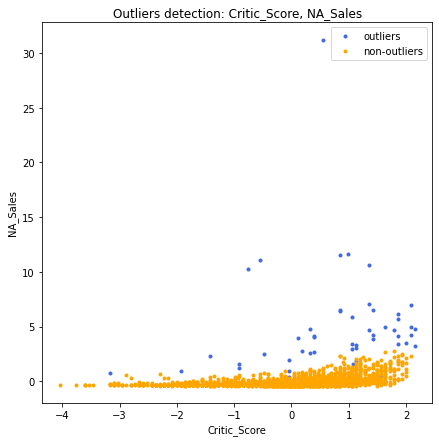

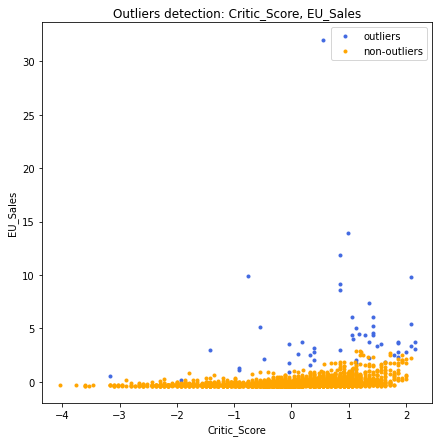

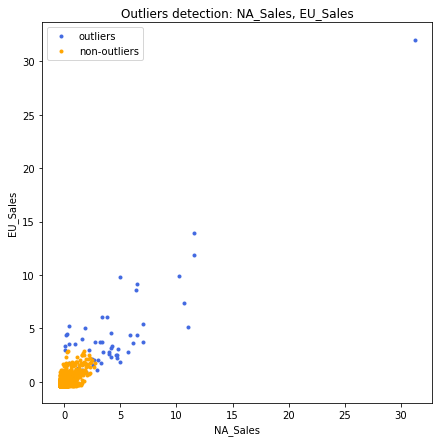

In [13]:
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

plot_2d_data_with_outliers(outliers, non_outliers, ("Critic_Score", "NA_Sales"))
plot_2d_data_with_outliers(outliers, non_outliers, ("Critic_Score", "EU_Sales"))
plot_2d_data_with_outliers(outliers, non_outliers, ("NA_Sales", "EU_Sales"))

data = drop_outliers_from_dataset(data, outliers)

### Clustering - results for different amounts of clusters

Performing Silhouette score analysis ... 

Used method: K-Means
Score for 2 clusters 0.4536140818934591 (+-8.840088790886839e-06)
Score for 3 clusters 0.41306702933749745 (+-0.00043864118509593503)
Score for 4 clusters 0.4282384382308509 (+-0.00012514593715233537)
Score for 5 clusters 0.384395816355607 (+-0.002146888433222417)
Score for 6 clusters 0.36012316193988936 (+-0.010166434478970927)
Score for 7 clusters 0.35472103452603787 (+-0.002255649909646406)
Score for 8 clusters 0.3629185792274676 (+-0.001308409489557006)
Score for 9 clusters 0.3360456796483507 (+-0.00206885049966493)
Score for 10 clusters 0.33715163014136174 (+-0.008772430951304564)
Score for 11 clusters 0.3289427502084467 (+-0.006929402362433654)
Score for 12 clusters 0.3297551292634868 (+-0.005628706033859038)
Score for 13 clusters 0.3216550333570332 (+-0.004052323649517757)
Score for 14 clusters 0.3193434276711367 (+-0.004853271053263913)
Score for 15 clusters 0.31660006889526626 (+-0.008690350517043574)
Score for 16

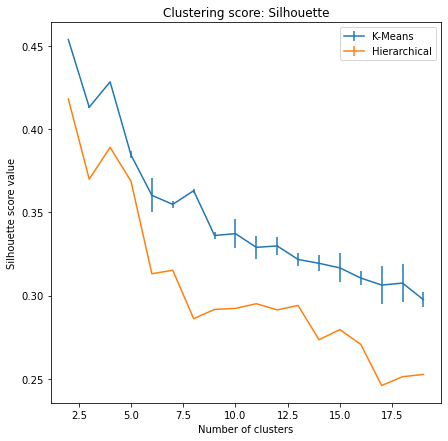

In [14]:
print("Performing Silhouette score analysis ... ")
numbers_of_clusters = range(2, 20)

print("\nUsed method: K-Means")
k_means_scores, k_means_errors = \
    perform_clustering_score_analysis(data, columns_used_for_clustering, numbers_of_clusters,
                                      k_means_multiple_dim_silhouette, 10)

print("\nUsed method: Hierarchical")
hierarchical_scores, hierarchical_errors = \
    perform_clustering_score_analysis(data, columns_used_for_clustering, numbers_of_clusters,
                                      hierarchical_multiple_dim_silhouette, 2)

scores = [k_means_scores, hierarchical_scores]
errors = [k_means_errors, hierarchical_errors]
methods = ["K-Means", "Hierarchical"]
plot_clustering_scores(numbers_of_clusters, scores, errors, methods, "Silhouette")


### Clustering - 4 clusters

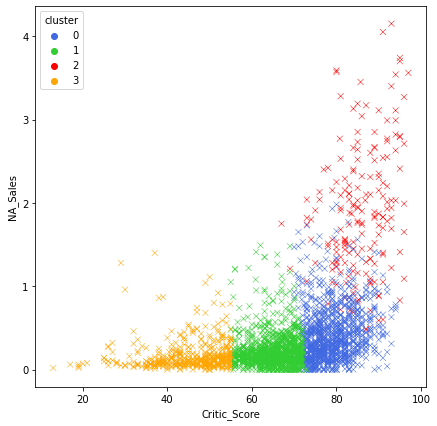

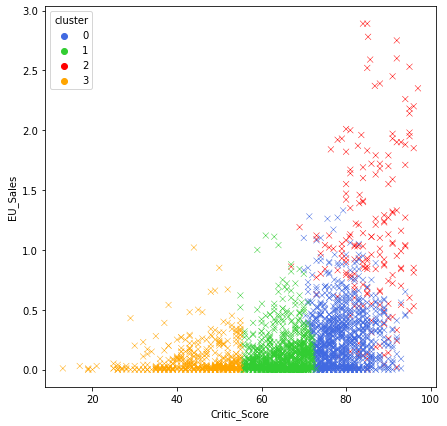

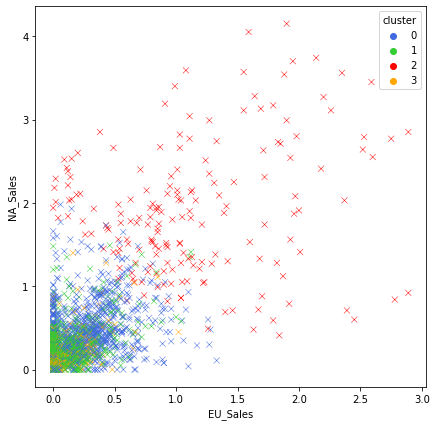

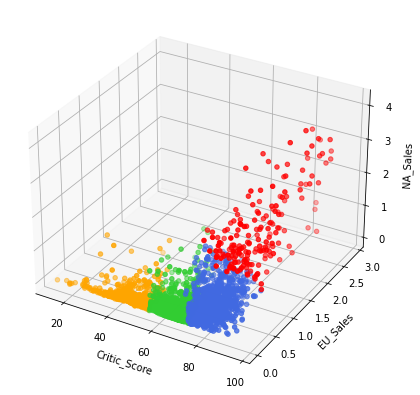

In [15]:
palette = ["royalblue", "limegreen", "red", "orange"]
clustered_data = k_means_clustering(data, columns_used_for_clustering, 4)
clustered_data[columns_used_for_clustering] = standardization.inverse_transform(clustered_data[columns_used_for_clustering])

sns.scatterplot(data=clustered_data, x="Critic_Score", y="NA_Sales", hue="cluster", palette=palette, marker='x')
plt.show()

sns.scatterplot(data=clustered_data, x="Critic_Score", y="EU_Sales", hue="cluster", palette=palette, marker='x')
plt.show()

sns.scatterplot(data=clustered_data, x="EU_Sales", y="NA_Sales", hue="cluster", palette=palette, marker='x')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
number_of_clusters = clustered_data["cluster"].max() + 1
for cluster_index in range(0, number_of_clusters):
    cluster_data = clustered_data[clustered_data["cluster"] == cluster_index]
    ax.scatter(cluster_data["Critic_Score"], cluster_data["EU_Sales"], cluster_data["NA_Sales"], c=palette[cluster_index])

ax.set_xlabel('Critic_Score')
ax.set_ylabel("EU_Sales")
ax.set_zlabel('NA_Sales')
plt.show()

### Check linearity for the cluster with a highest mean NA_Sales

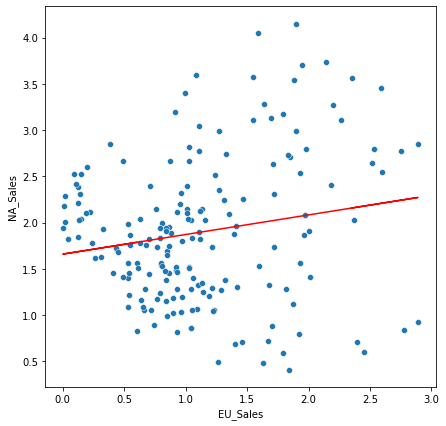

Pearson correlation coefficient: 0.1796812742351817


In [16]:
examined_cluster = 0
current_mean = 0
for cluster_index in range(4):
    mean = clustered_data[clustered_data["cluster"] == cluster_index].mean()["NA_Sales"]
    if mean > current_mean:
        examined_cluster = cluster_index
        current_mean = mean

examined_cluster_data = clustered_data[clustered_data["cluster"] == examined_cluster]

reg = LinearRegression().fit(examined_cluster_data["EU_Sales"].to_numpy().reshape(-1, 1), examined_cluster_data["NA_Sales"])

fit_data = [reg.coef_ * x + reg.intercept_ for x in examined_cluster_data["EU_Sales"]]

ax = sns.scatterplot(data=examined_cluster_data, x="EU_Sales", y="NA_Sales")
plt.plot(examined_cluster_data["EU_Sales"], fit_data, c="red")
plt.show()

x = np.array(examined_cluster_data["EU_Sales"], dtype='float')
y = np.array(examined_cluster_data["NA_Sales"], dtype='float')

pearson_correlation = stats.pearsonr(x, y)
print("Pearson correlation coefficient: {}".format(pearson_correlation[0]))

### Clusters analysis - variables distributions for each cluster

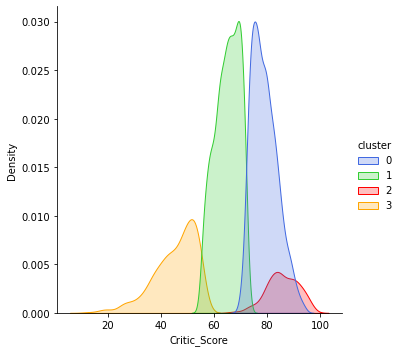

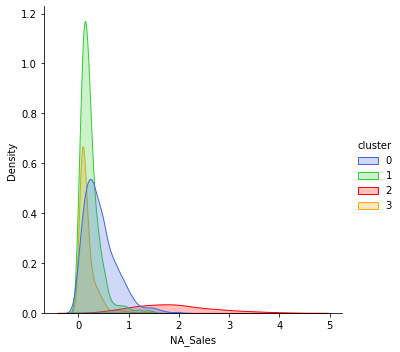

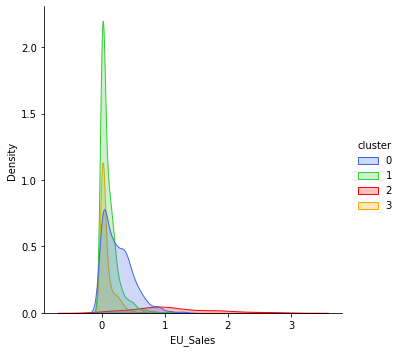

In [17]:
sns.displot(clustered_data, x="Critic_Score", hue="cluster", kind="kde", fill=True, palette=palette)
sns.displot(clustered_data, x="NA_Sales", hue="cluster", kind="kde", fill=True, palette=palette)
sns.displot(clustered_data, x="EU_Sales", hue="cluster", kind="kde", fill=True, palette=palette)

### Clusters analysis - variables means for each cluster

         Critic_Score  NA_Sales  EU_Sales
cluster                                  
0           79.048325  0.431604  0.259279
1           65.033302  0.227898  0.106735
2           85.734239  1.895870  1.119185
3           45.401774  0.172439  0.078958


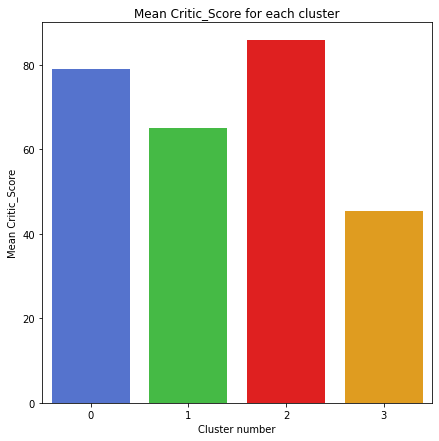

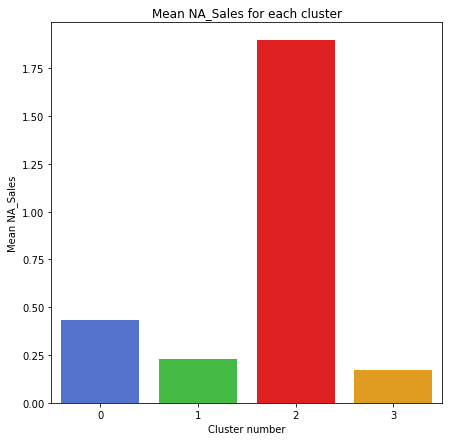

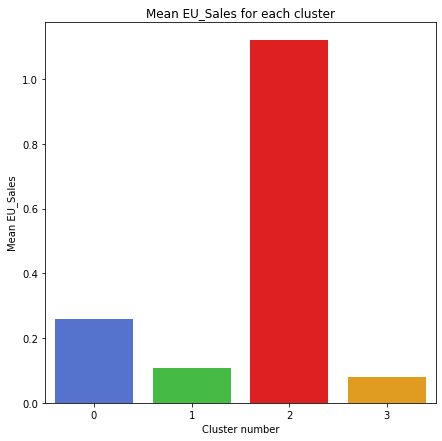

In [18]:
print(clustered_data.groupby("cluster").mean())

plot_means_in_clusters_for_given_column(clustered_data, "Critic_Score", colors=palette)
plot_means_in_clusters_for_given_column(clustered_data, "NA_Sales", colors=palette)
plot_means_in_clusters_for_given_column(clustered_data, "EU_Sales", colors=palette)

### Clusters analysis - categorical variables

<AxesSubplot:xlabel='counts', ylabel='Platform'>

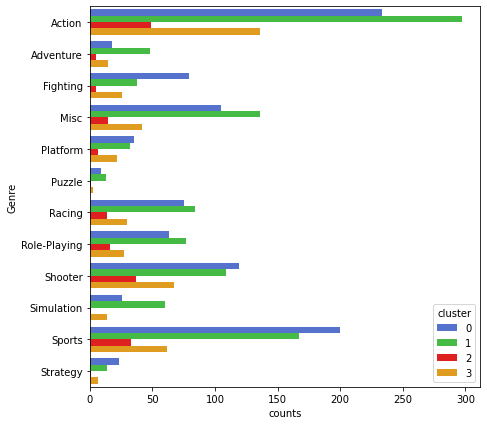

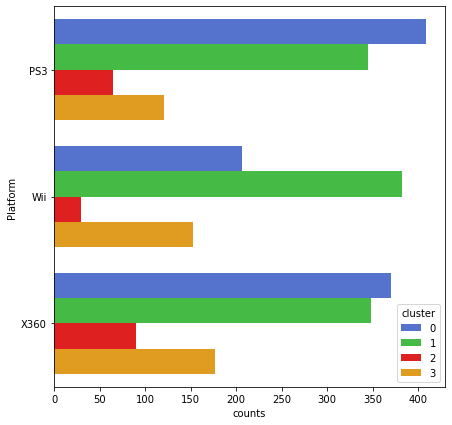

In [19]:
# genres
grouped_by_genre = clustered_data.groupby(["cluster", "Genre"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Genre", hue="cluster", data=grouped_by_genre, orient='h', palette=palette)

# platforms
grouped_by_platform = clustered_data.groupby(["cluster", "Platform"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Platform", hue="cluster", data=grouped_by_platform, orient='h', palette=palette)

### Classification (to clusters)

In [20]:
# prepare dataset
clustered_data[columns_used_for_clustering] = standardization.transform(clustered_data[columns_used_for_clustering])
clustered_data = clustered_data.drop(categorical_columns, axis=1)

# KNN classification
print("Performing KNN classification - leave one out method")
classification_accuracy = k_neighbours_leave_one_out(clustered_data, "cluster", 3)
print("Score: {}".format(classification_accuracy))

# Decision tree classification
print("Performing decision tree classification - leave one out method")
classification_accuracy = decision_tree_leave_one_out(clustered_data, "cluster")
print("Score: {}".format(classification_accuracy))


Performing KNN classification - leave one out method
Score: 0.9858998144712431
Performing decision tree classification - leave one out method
Score: 0.9807050092764379
